

# Frequency and time-frequency sensor space analysis

This notebook shows how to explore the spectral content
of your data in the frequency and time-frequency domain in sensor space, e.g. using Fourier analysis and wavelets.


In [21]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html
# https://mne.tools/stable/auto_examples/time_frequency/time_frequency_global_field_power.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

In [22]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import sample

Set parameters and create data epochs - nothing new here:



In [23]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
tmin, tmax = -0.5, 1.  # note larger epoch than for ERPs/ERFs, to allow for lower frequencies
event_id = 1

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel="STI 014")

include = []
raw.info["bads"] += ["MEG 2443", "EEG 053"]  # bads + 2 more

picks = mne.pick_types(
    raw.info, meg=True, eeg=True, eog=True, stim=False, include=include, exclude="bads"
)

# Load condition 1
event_id = 1
# events = events[:10]  # take 10 events to keep the computation time low
# Use linear detrend to reduce any edge artifacts
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=dict(grad=4000e-13, eog=150e-6),
    preload=True,
    detrend=1,
)

Opening raw data file /imaging/opendata/mne/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.49948803289596966, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 72 events and 902 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Reject

As a quick sanity check, let's look at the evoked response:

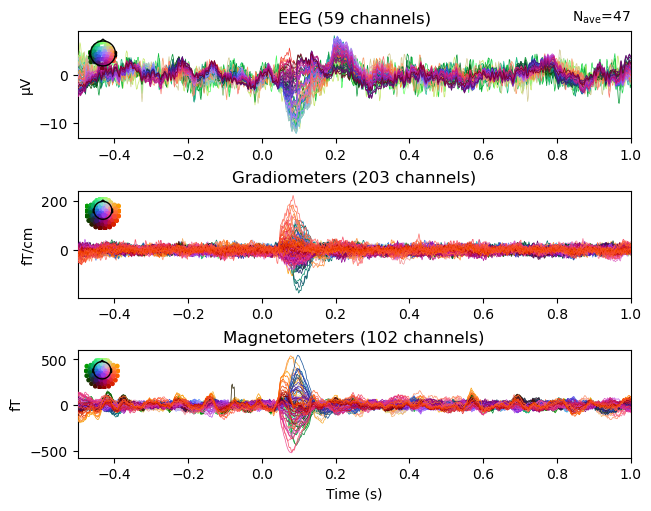

In [24]:
epochs.average().plot();

**Exercise:**<br>
- Why does this look noisier than in previous examples?


## Frequency analysis

Now we can explore the frequency content of our epochs using the frequency spectrum (Power Spectral Density, PSD).



    Using multitaper spectrum estimation with 7 DPSS windows
Plotting amplitude spectral density (dB=False).
Averaging across epochs before plotting...
Averaging across epochs before plotting...
Averaging across epochs before plotting...


/imaging/local/software/mne_python/jeffmneV2/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


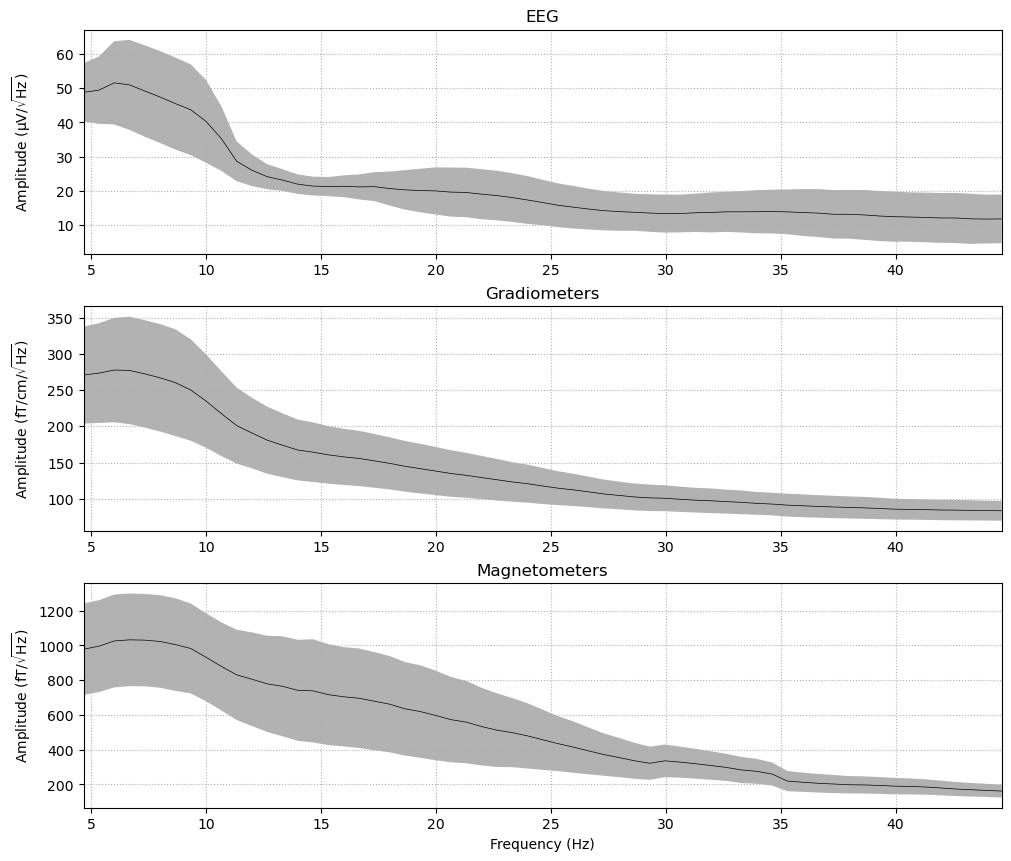

In [25]:
psds = epochs.compute_psd(fmin=4., fmax=45.)  # power spectral density

# here we plot the average across channels
psds.plot(
    average=True, amplitude=True, dB=False, picks="data", exclude="bads"
);

**Exercise:** <br>
- Why did we omit low frequencies (below 5Hz) from this plot?

We can look at the topographies in different frequency bands. 
(Note: You can also specify your own frequencies).



Averaging across epochs before plotting...


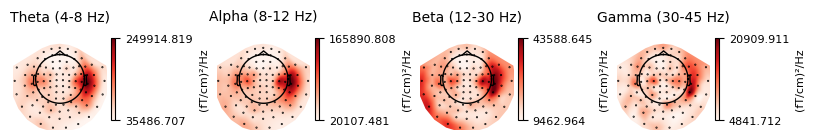

In [26]:
bands = {'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}
psds.plot_topomap(bands=bands, ch_type="grad", normalize=False, contours=0);

Note: You can access the spectra across epochs and the corresponding frequencies as a numpy array with dimensions
 ``(n_epochs, n_sensors, n_freqs)``.



In [27]:
print(psds.freqs.shape)
print(psds.data.shape)

(61,)
(47, 364, 61)



## Time-frequency analysis
Above, we computed a frequency spectrum (power spectral density) across the whole epoch. This assumes that periodic signals are stable across the whole epoch - which they are not, especially for event-related activity.

We would like to see how activity in frequency bands evolves over time.



Our first idea may be to band-pass-filter the data in a specific frequency band and then look at the time course. For example, we can inspect the time course of the alpha rhythm in our raw data:

In [28]:
raw_bp = raw.copy().load_data().filter(l_freq=8, h_freq=12.)  # band-pass filter
raw_bp.plot();

Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 993 samples (1.653 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    1.2s finished


Using qt as 2D backend.


We can do this with any frequency band we like.

**Exercise:**<br>
- Change the above frequency band, e.g. to 20-25 Hz, and see what happens. You may need to change the scaling in the display.


After band-pass filtering, the data will always look "oscillatory" - that's what a band-pass filter does.

In order to test whether activity is specific to a narrow frequency band, we need to test multiple frequency bands and compare them. We will then also want the signal power (and possibly phase).

A principled way to do time-frequency analysis is via **Wavelets** ("little waves"):
- Wavelets produce time courses that reflect activity in a frequency band around a centre frequency over time.
- There is a trade-off between the temporal and frequency resolution of a wavelet.
- The temporal resolution of a wavelet is affected by the "number of cycles" that we use to fit the wavelets to the data.
- A large number of cycles provides higher frequency but lower temporal resolution. 
- For low frequencies, wavelets may become too long to fit into an epoch.
- A common procedure is to make the number of cycles dependent on the frequency, with more cycles at higher frequencies.

Let's create and plot a wavelet to make sure we know what we are talking about:

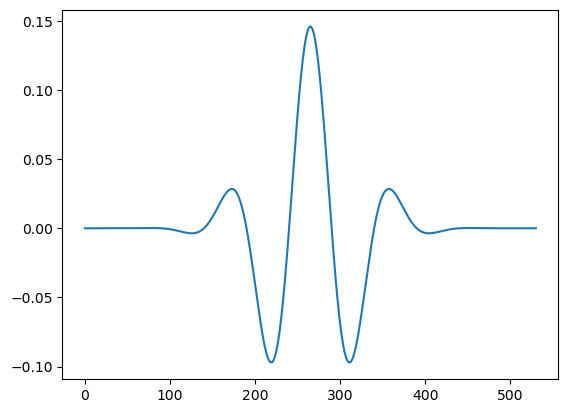

In [46]:
freq = 10.  # centre frequency of the wavelet
sfreq = 1000.  # assumed sampling rate of the data
wavelet = mne.time_frequency.morlet(sfreq, freq, n_cycles=freq/3.)  # Morlet wavelet as array
plt.plot(wavelet)

**Exercises:**
* Change the values for centre frequency and number of cycles and observe what happens.

In [31]:
# we compute power over time for a list of frequencies
freqs = np.logspace(*np.log10([6, 35]), num=8)

n_cycles = freqs / 2.0  # number of cycles

power, itc = epochs.compute_tfr(
    method="morlet",  # a common type of wavelet (but there are more)
    freqs=freqs,
    n_cycles=n_cycles,
    average=True,
    return_itc=True,  # "inter-trial coherence" (ignore for now)
    decim=3,
)

print('The power object now consists of %d channels, %d frequencies, and %d timepoints' % (power.shape))

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.0s


The power object now consists of 364 channels, 8 frequencies, and 301 timepoints


[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:    3.9s finished


Applying baseline correction (mode: logratio)


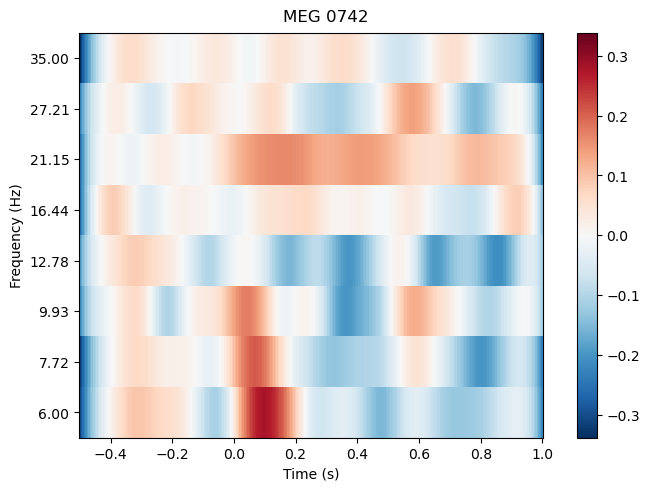

[<Figure size 640x480 with 2 Axes>]

In [32]:
maxch = np.abs(epochs.average().data).sum(axis=1).argmax(axis=0)  # channel with maximum amplitude

power.plot(picks=[maxch], baseline=(-0.5, 0), mode="logratio", title=power.ch_names[82])

We can also plot the topography of power at a particular latency and frequency.

Applying baseline correction (mode: percent)


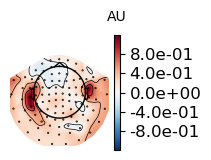

In [33]:
power.plot_topomap(fmin=8, fmax=12, ch_type="grad", tmin=0.05, tmax=0.25, baseline=(-0.5, 0), mode="percent", show=False);

**Exercises:** <br>
* Check different 'mode' options. Why is it recommended to normalise power with respect to baseline?
* Note the vertical "blue stripes" at the beginning and end of the epoch. Do you think they reflect reliable activation?

## Inspect power

<div class="alert alert-info"><h4>Note</h4><p>In ther active view you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>



We can plot all channels together, but this is hard to interpret.

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


/imaging/local/software/mne_python/jeffmneV2/lib/python3.11/site-packages/mne/baseline.py:115: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


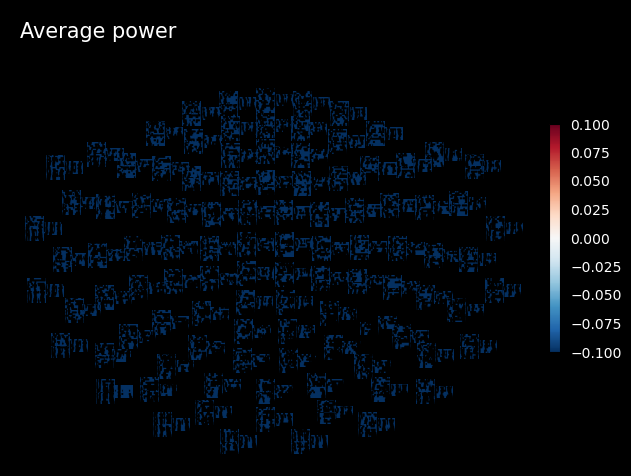

In [34]:
power.apply_baseline(baseline=(-0.5, 0), mode='logratio')
power.plot_topo(baseline=(-0.5, 0), mode="logratio", title="Average power");

You can also create a joint plot showing both the aggregated TFR
across channels and topomaps at specific times and frequencies to obtain
a quick overview of activity across time and space.



Multiple channel types selected, returning one figure per type.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


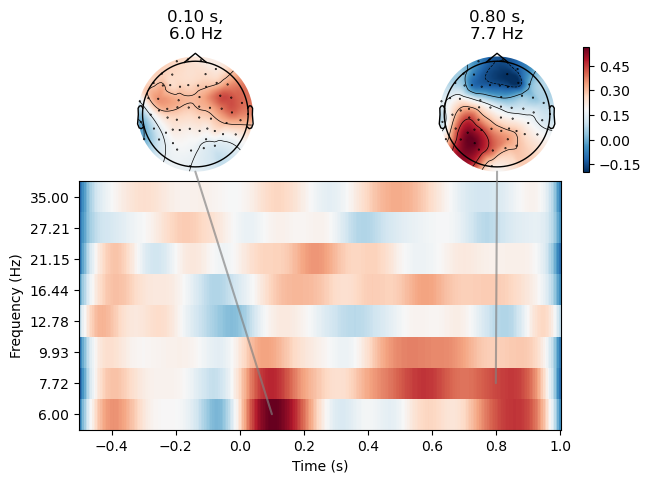

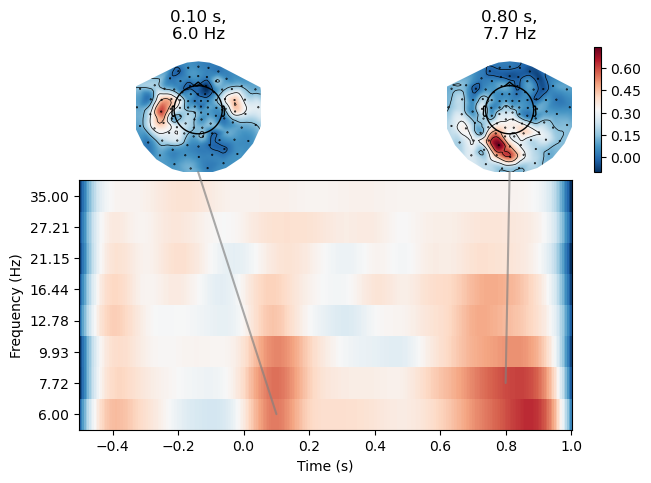

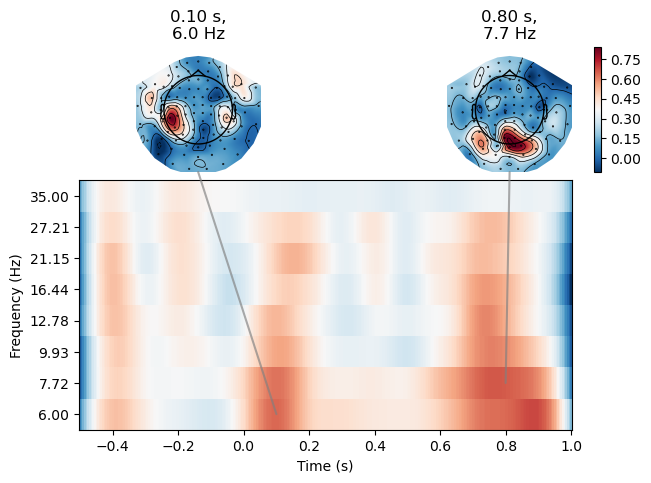

In [35]:
power.plot_joint(
    baseline=(-0.5, 0), mode="mean", tmin=-0.5, tmax=1, timefreqs=[(0.1, 6), (0.8, 8)]
);

## Inter-Trial Coherence (ITC)



"Inter-Trial Coherence" (ITC) is a measure of the phase consistency of responses across trials within a frequency band. It is not a measure of connectivity between channels or regions (we will talk about that type of "coherence" later).

No baseline correction applied


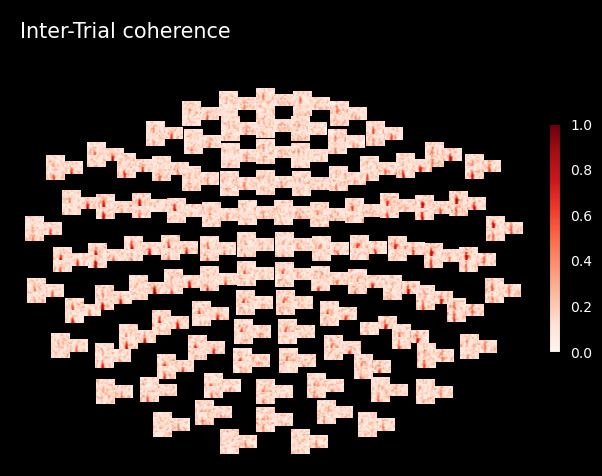

In [36]:
itc.plot_topo(title="Inter-Trial coherence", vmin=0.0, vmax=1.0, cmap="Reds");

Multiple channel types selected, returning one figure per type.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


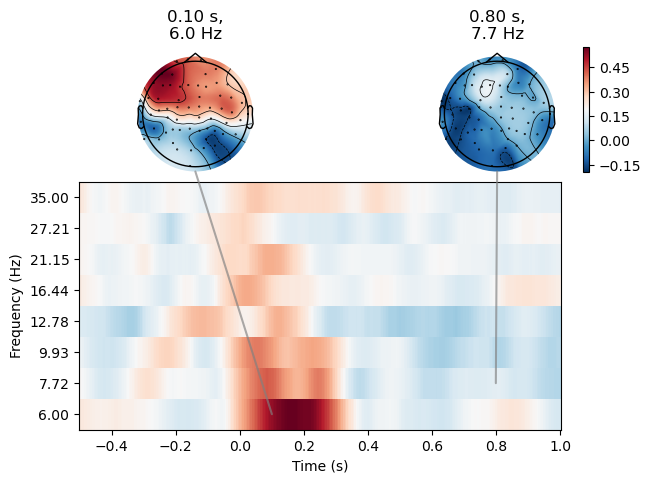

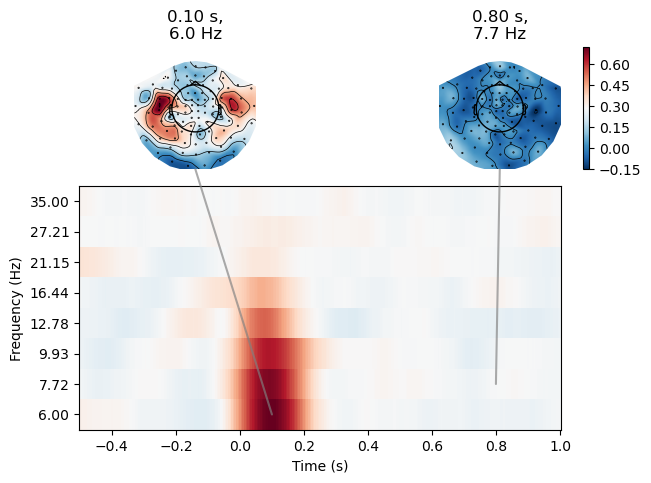

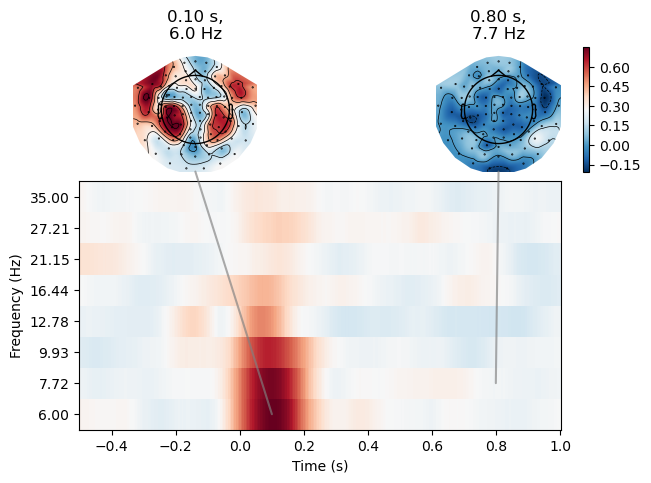

Channels marked as bad:
['MEG 2443', 'EEG 053', 'MEG 2443', 'EEG 053']


In [37]:
itc.plot_joint(
    baseline=(-0.5, 0), mode="mean", tmin=-0.5, tmax=1, timefreqs=[(0.1, 6), (0.8, 8)]
);

**Exercise:** <br>
- Compare the power plots above with the ITC plots here. Do you notice a difference? What might explain it?

Note that baseline normalisation can be applied to power objects directly or done in plots.

Make sure you use appropriate baseline normalisation before you process power data, e.g. using statistics, and not just in plots.

    # power.apply_baseline(baseline=(-0.5, 0), mode='logratio')

